# TraceBERT
### Objective
In this notebook, we aim to train a BERT-style model using standard MLM on an _abstracted_ Java trace dataset consisting of two datasets generated from Commonsio and Nettyio.

To achieve this and evaluate our performance, we apply the following methodology:
1. Train a tokenizer specifically designed for our data, which occurs in the form
```
performExpensiveLogSetup [ENTRY] void [CALL] java.io.PrintStream println java.lang.String void [CALL] java.lang.Math pow double|double double [CALL] java.lang.Math sqrt double double [CALL] java.io.PrintStream println java.lang.String void [EXIT]
```

We want each token to be either the method name e.g. _performExpensiveLogSetup_ or an event in the trace _[EXIT]_. This allows us to represent long traces without using a fancy transformer.

2. We define a model based on BERT, but somewhat smaller.

| Hyperparameter               | Value |
|------------------------------|-------|
| vocab_size                   | 9582  |
| max_position_embeddings      | 768   |
| intermediate_size            | 2048  |
| hidden_size                  | 512   |
| num_attention_heads          | 8     |
| num_hidden_layers            | 6     |
| type_vocab_size              | 5     |
| hidden_dropout_prob          | 0.1   |
| attention_probs_dropout_prob | 0.1   |

3. We load our dataset (Commonsio traces) and split by train/dev/test (dev overlaps with train, dev does not).

4. We tokenize our dataset, and proceed to inspect it to see some of the most frequent function names across the train/dev/test split.

5. We define a trainer class to pretrain a BERT model from scratch. During training, we evaluate our performance on the dev set and plot our loss curve for a heldout slice of the training dataset.

6. We begin our model interpretation by loading a new dataset consisting of Nettyio traces. This serves as a true evaluation set, as presumably Nettyio traces are more distant from Commonsio traces. We extract all examples of the `compare` method. We do the same for our Commonsio training dataset, and slice the datasets such that their lengths are equal (i.e. if there are 1500 examples from Commonsio, and 200 from Nettyio, we select the first 200 from Commonsio).

7. We proceed to define a function to extract the embedding of the [CLS] token from the trained model. We then extract the embeddings for ten thousand examples from Commonsio, the Commonsio and Nettyio `compare` examples, and extract embeddings for another Commonsio function, `checkPositionIndexes`.

8. We then construct various FAISS (vector search) indexes on the first 10k examples from Commonsio (compute reasons). These indexes allow us to search in the vector space for similar embeddings based on Inner Product and Euclidean distances. We show that embeddings are able to find similar functions in the space. We also calculate cosine similarities, and perform a t-test on a sample of distances of embeddings of the same function, and another sample of embeddings from a different function.

9. We then proceed to perform a similar analysis using tSNE projection/clustering, showing that functions of the same name cluster, and different functions cluster elsewhere. We also cluster ten thousand traces from Commonsio.

10. As a toy, we demonstrate that TraceBERT is able to recover missing calls and function names.

Re-calc embeddings without function

### Generic imports

In [ ]:
# Force tokenizers to run in parallel
%env TOKENIZERS_PARALLELISM=true
%env HF_DATASETS_CACHE=hf_cache
%env NCCL_DEBUG=INFO
%env CUDA_VISIBLE_DEVICES=2,4,5
import wandb
import torch
import numpy as np
import faiss
from collections import Counter
import matplotlib.pyplot as plt

# Check if CUDA is available (Docker attached correctly)
print(f"CUDA: {torch.cuda.is_available()}")

In [ ]:
print(torch.cuda.device_count())

In [ ]:
wandb.login() # log in weights & biases

### Trace Tokenizer

In [ ]:
from tokenizers import Tokenizer, Regex
from tokenizers.models import WordLevel
from tokenizers.processors import BertProcessing
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Split
from tokenizers.normalizers import Strip

#### Tokenizer set up

In [ ]:
exp = Regex("(^((\w)+(?=\s)))|((\[ENTRY\]\ (\w|\||\.)+)\s)|((\[CALL\]\ (\w|\||\.|\s)+)(?=\ \[))+|(\[EXIT\])")

trace_tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
trace_tokenizer.add_special_tokens(["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])#, "[ENTRY]", "[EXIT]", "[CALL]")
trace_tokenizer.normalizer = Strip()
trace_tokenizer.pre_tokenizer = Split(pattern=exp, behavior="removed",invert=True)
trace_tokenizer.post_processor = BertProcessing(sep=("[SEP]", 0),cls=("[CLS]", 1))
VOCAB_SIZE = 10000
trainer = WordLevelTrainer(
    vocab_size=VOCAB_SIZE, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
)

In [ ]:
# Sanity check on the pre_tokenizer
trace_tokenizer.pre_tokenizer.pre_tokenize_str(
        (
        "[ENTRY] void "
        "[CALL] java.io.PrintStream println java.lang.String void "
        "[CALL] java.lang.Math pow double|double double "
        "[CALL] java.lang.Math sqrt double double "
        "[CALL] java.io.PrintStream println java.lang.String void "
        "[EXIT]")
    )


#### Train tokenizer

In [ ]:
#t = Tokenizer.from_file("trace_tokenizer_google.json")
import re

In [ ]:
dict(filter(lambda elem: re.search('^(?!\[ENTRY\]).*',elem[0]),trace_tokenizer.get_vocab().items()))

In [ ]:
{k: v for k, v in sorted(t.get_vocab().items(), reverse=True, key=lambda item: item[1])}

In [ ]:
trace_tokenizer.get_vocab_size()

In [ ]:
# Sanity check on the pre_tokenizer
t.pre_tokenizer.pre_tokenize_str(
        (
        "[ENTRY] void "
        "[CALL] java.io.PrintStream println java.lang.String void "
        "[CALL] java.lang.Math pow double|double double "
        "[CALL] java.lang.Math sqrt double double "
        "[CALL] java.io.PrintStream println java.lang.String void "
        "[EXIT]")
    )

In [ ]:
files = ["../projsplit/google_for_vocab.txt"] # Define files to train on
trace_tokenizer.train(files, trainer)
trace_tokenizer.save("trace_tokenizer_google_no_method_s.json") # Save tokenizer

In [ ]:
trace_tokenizer.get_vocab()

# TraceBERT Model

### Load pretrained tokenizer fast

HuggingFace nicely provided a high performance Rust implementation, let's use it.

In [ ]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast
fast_tokenizer = BertTokenizerFast(
                                        tokenizer_file="trace_tokenizer_google_no_method_s.json",
                                        return_special_tokens_mask=True,
                                        return_token_type_ids=True
                                    )

### Define TraceBERT config

There *is* a reason for defining the config so early in the notebook: when we encode our dataset we want to perform truncation/padding based on our model's size, so it is easier to know this in advance.

In [ ]:
from transformers import BertConfig

In [ ]:
scale_factor = 1 

tracebert_config = BertConfig(
    # VOCAB_SIZE plus some extra for special tokens
    vocab_size=(fast_tokenizer.vocab_size + 3),
    max_position_embeddings=int(768*scale_factor),
    intermediate_size=int(2048*scale_factor),
    hidden_size=int(512*scale_factor),
    num_attention_heads=8,
    num_hidden_layers=6,
    type_vocab_size=5,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    output_hidden_states=True,
    return_dict=True
)

#### Sanity check tokenizer

In [ ]:
fast_tokenizer.decode(fast_tokenizer.encode("[EXIT]"))

In [ ]:
fast_tokenizer.vocab_size

## Load datasets

In [ ]:
from datasets import load_dataset
import datasets

#### Train

In [ ]:
google_train_dataset = load_dataset(
                        'text',
                        data_files='../projsplit/google.txt',
                        split='train[:40%]' # Load first 5% of dataset
                    )

In [ ]:
# Sanity check
google_train_dataset

#### Dev

In [ ]:
google_dev_dataset = load_dataset(
                        'text',
                        data_files='../projsplit/google.txt',
                        split='train[:1500]' # WARNING: we are loading the first 1.5k rows for dev
                    )

In [ ]:
# Sanity check
google_dev_dataset

#### Test

In [ ]:
google_test_dataset = load_dataset(
                        'text',
                        data_files='../projsplit/google.txt',
                        split='train[40%:44%]' # Load 3k rows for test
                    )

In [ ]:
# Sanity check
google_test_dataset

## Tokenize/encode datasets

In [ ]:
# Define tokenization function
# Max length: length of model
# Truncation: true (defaults to max example length)
# Padding: true (until truncation length)
def tokenize_trace(examples):
    return {
        **fast_tokenizer(
            examples['method_body'],
            max_length = tracebert_config.hidden_size,
            truncation=True,
            padding=True
        )
    }

def extract_trace(examples):
        return { 'method_name': [ t[:t.index(' ')] for t in examples['text'] ],
        'method_body': [ t[t.index(' ')+1:] for t in examples['text'] ] }

#### Tokenize training dataset

In [ ]:
google_train_dataset_enc = (google_train_dataset
                            .map(
                                            extract_trace,
                                            batched=True
                                        )
                            .remove_columns('text')
                            .map(
                                            tokenize_trace,
                                            batched=True,
                                num_proc=32
                                        )
                           )

In [ ]:
# Sanity check
google_train_dataset_enc[0]

In [ ]:
# Save tokenized version
google_train_dataset_enc.save_to_disk('datasets/google_train_dataset_enc_no_name_27m')

#### Tokenize dev dataset

In [ ]:
google_dev_dataset_enc = google_dev_dataset.map(
                                            extract_trace,
                                            batched=True
                                        ).remove_columns('text')

In [ ]:
# Sanity check
google_dev_dataset_enc.to_csv('google_dev_dataset_test')#, num_proc=64)

In [ ]:
# Save tokenized version
google_dev_dataset_enc.save_to_disk('datasets/google_dev_dataset_enc')

#### Tokenize test dataset

In [ ]:
google_test_dataset_enc = (google_test_dataset.map(
                                            extract_trace,
                                            batched=True
                                        ).remove_columns('text')
                            .map(
                                            tokenize_trace,
                                            batched=True,
                                num_proc=32
                                        )
                           )

In [ ]:
# Sanity check
google_test_dataset_enc

In [ ]:
# Save tokenized version
google_test_dataset_enc.save_to_disk('datasets/google_test_dataset_enc_no_2_7m')

### Load tokenized datasets (if already saved)

In [ ]:
google_train_dataset_enc = datasets.load_from_disk('datasets/google_train_dataset_enc_no_name')
#google_dev_dataset_enc = datasets.load_from_disk('datasets/google_dev_dataset_enc')
google_test_dataset_enc = datasets.load_from_disk('datasets/google_test_dataset_enc_no_name')


## Inspect datasets

In [ ]:
train_func_frequencies = Counter(google_train_dataset_enc['method_name']).most_common()

In [ ]:
train_func_frequencies

In [ ]:
dev_func_frequencies = Counter(google_dev_dataset_enc['func_name']).most_common()

In [ ]:
test_func_frequencies = Counter(google_test_dataset_enc['func_name']).most_common()

In [ ]:
def plot_freq(counter):
    counts = [ (index, value[1]) for index, value in enumerate(counter) ]
    plt.scatter(*zip(*counts))
    plt.show()

In [ ]:
plot_freq(train_func_frequencies[:100])
print(train_func_frequencies[:15])

## Define Trainer for experiment

In [ ]:
from transformers import TrainingArguments, DataCollatorForWholeWordMask, Trainer, BertForMaskedLM

We define our model from the BertForMaskedLM class

In [ ]:
tracebert_model = BertForMaskedLM.from_pretrained("tracebert_009")#BertForMaskedLM(tracebert_config)

In [ ]:
# performs masking
data_collator = DataCollatorForWholeWordMask(
                    tokenizer=fast_tokenizer,
                    mlm=True,
                    mlm_probability=0.15
                )

training_args = TrainingArguments(
    "tracebert_009", # Model name/directory
    run_name='tracebert_20220201_1', # experiment name
    # group_by_length=True, # minimize padding
    # overwrite the content of the output directory
    # continue training if output_dir points to a checkpoint directory.
    overwrite_output_dir=True,
    report_to = 'wandb',
    #num_train_epochs=3, # defaults to 3
    prediction_loss_only=False, # only return loss during eval
    save_steps=500, # save checkpoint every 5k steps
    save_total_limit=3, # save only last 3 checkpoints (we're low on space ☹️)
    #eval_accumulation_steps=1000, # number of steps to accumulate before moving to CPU, enable if running out of CUDA RAM
    logging_steps=300, # num steps before train loss is logged
    eval_steps=1000, # num steps before eval loss is calculated
    # max_steps=1000, # max number of steps to train
    save_strategy='steps',
    evaluation_strategy='steps',
    per_device_train_batch_size=44, # increase batch size
    per_device_eval_batch_size=16, # increase batch size
)


trainer = Trainer(
    model=tracebert_model,
    tokenizer=fast_tokenizer,
    data_collator=data_collator,
    args=training_args,
    train_dataset=google_train_dataset_enc, # DEFINE DATASETS !!!
    eval_dataset=google_test_dataset_enc,
    #bf16=True,
    #fp16=False,
    #fp16_opt_level='01', # [‘O0’, ‘O1’, ‘O2’, and ‘O3’]
    #half_precision_backend='auto', # apex or amp
    #bf16_full_eval=False,
    #fp16_full_eval=False,
    #sharded_ddp=False,
    #deepspeed=None, # json file or dict or json
    #compute_metrics=compute_metric, # if custom metric function available
)

In [ ]:
google_train_dataset_enc

#### Train model

# Currently does 52 steps/min
***** Running training *****
  Num examples = 3376066
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 79128

In [ ]:
torch.cuda.empty_cache()

In [ ]:
%%wandb
trainer.train(resume_from_checkpoint=False)

In [ ]:
wandb.finish()

In [ ]:
# Save model manually if needed
trainer.save_model()

In [ ]:
trainer.evaluate()

# Interpret model

### Retrieve examples of specific function name

In [ ]:
def exact_str_match(x,y):
    return x==y
def str_contains(x,y):
    return x in y

def trim(filt, trim_value=0., trim='fb'):
    """
    Copied from np.trim_zeros, but allows the trim value to be specified
    """
    first = 0
    trim = trim.upper()
    if 'F' in trim:
        for i in filt:
            if i != trim_value:
                break
            else:
                first = first + 1
    last = len(filt)
    if 'B' in trim:
        for i in filt[::-1]:
            if i != trim_value:
                break
            else:
                last = last - 1
    return filt[first:last]

# pass comparator which (x,y) where x is needle and y is haystack
def retrieve_func_examples(dataset, function_name, comparator=exact_str_match):
    return dataset.filter(lambda trace: comparator(function_name, trace['method_name']), num_proc=64)

def retrieve_func_examples_len(dataset, function_name, length, comparator=exact_str_match):
    return dataset.filter(lambda trace: comparator(function_name, trace['method_name']) and len(trim(trace['input_ids'],trim_value=3)) > length, num_proc=64)

In [ ]:
func_compare_google = retrieve_func_examples(
                            google_train_dataset_enc,
                            'compare',
                            comparator=exact_str_match
                        )

In [ ]:
trim(google_train_dataset_enc[0]['input_ids'],trim_value=3)

In [ ]:
func_compare_google

#### Load Netty dataset

In [ ]:
netty_dataset_enc = (
                        load_dataset(
                            'text',
                            data_files='../projsplit/netty.txt',
                            split='train[:10000]')
                        .map(
                        # WARNING: using a tokenizer NOT trained on this dataset
                        # could result in poor performance due to UNKs
                            tokenize_trace,
                            batched=True,
                            num_proc=64
                        )
                    )

In [ ]:
netty_dataset_enc

### Retrieve all examples of 'compare' function

In [ ]:
func_compare_netty = retrieve_func_examples(
                            netty_dataset_enc,
                            'compare',
                            comparator=exact_str_match
                        )

#### Find the minimum number of examples of func in both datasets (class balance)

In [ ]:
minimum_funcs = min(len(func_compare_netty), len(func_compare_google))
minimum_funcs

In [ ]:
func_compare_netty = func_compare_netty.select(range(0, minimum_funcs))
func_compare_google = func_compare_google.select(range(0, minimum_funcs))

#### Pick another function from Commonsio for comparisons

In [ ]:
func_CPI_google = retrieve_func_examples(
                            google_train_dataset_enc,
                            'checkPositionIndexes',
                            comparator=exact_str_match
                        )

Now we have two datasets with an equal amount of examples for a particular method, we now load these examples into the model and extract the embeddings

# (Re)load pretrained model for embeddings

If the model is not loaded yet, select a pretrained model to generate embeddings

In [ ]:
tracebert_model = BertForMaskedLM.from_pretrained('tracebert_009')
# or 
# or BertModel.from_pretrained('path_to_model_dir', add_pooling_layer=True)
#tracebert_model

We must ensure/assert that the model class will return the hidden states

In [ ]:
tracebert_model.config.output_hidden_states = True
tracebert_model.config.return_dict = True
assert tracebert_model.config.output_hidden_states == True

Define a function to load examples and extract hidden states from model as numpy arrays

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def calculate_embeddings(examples, method='hidden_state'):
    with torch.no_grad(): # no autograd if we don't train
        if method == 'hidden_state':
            # get the hidden state of the [CLS] token
            # we first grab the hidden states from the model,
            # then take the last layer, [-1], and convert it to a 3D
            # numpy array. N is number of examples in batch.
            # L is number of tokens (longest example fixes L)
            # D is number of hidden states
            # the shape is (N, L, D)
            # since [CLS] is always first, if we slice
            # (N, L[:1], D) we will get the hidden dim of the [CLS] token.
            # since L is now always 1, it is useless, and we can squeeze it out
            # now the shape is (N, D) where each example has 512 vectors
             # **fast_tokenizer(
             #    examples['method_body'],
             #    max_length = tracebert_config.hidden_size,
             #    truncation=True,
             #    padding=True,
             #         return_tensors="pt"
            #print(f"input_ids={torch.tensor(examples['input_ids']).shape}, attention_mask={torch.tensor(examples['attention_mask']).shape}, token_type_ids={torch.tensor(examples['token_type_ids']).shape}")
            b = tracebert_model(
                        input_ids=pad_sequence([torch.tensor(x) for x in examples['input_ids']], padding_value=3, batch_first=True),
                        attention_mask=pad_sequence([torch.tensor(x) for x in examples['attention_mask']], batch_first=True),
                        token_type_ids=pad_sequence([torch.tensor(x) for x in examples['token_type_ids']], batch_first=True)
                    ).hidden_states[-1].numpy()[:,:1,:].squeeze()
            return { 'embedding': b }
        elif method == 'pooler_output':
            return tracebert_model(examples).pooler_output.numpy() # shape [n, 512]

In [ ]:
longish = google_train_dataset_enc.filter(lambda x: x['len'] > 10, num_proc=32)

In [ ]:
longish

In [ ]:
#fast_tokenizer.decode(
counts_t = dict(Counter(longish['method_name']))

In [ ]:
sorted(counts_t)

In [ ]:
filtered = dict(filter(lambda elem: elem[1] > 60 and elem[1] < 10000, counts_t.items()))

In [ ]:
filtered

In [ ]:
sample_ten_func_names = random.sample(sorted(filtered), 10)

In [ ]:
import statistics
import random
statistics.mean(counts_t.values())

In [ ]:
from tqdm.notebook import trange, tqdm

In [ ]:
google_train_dataset_enc = google_train_dataset_enc.map(lambda x: { 'len': len(trim(x['input_ids'],trim_value=3)) },num_proc=8)

In [ ]:
google_train_dataset_enc

In [284]:
ten_funcs = {
 }

for func in tqdm(sample_ten_func_names):
    ten_funcs[func] = google_train_dataset_enc.filter(lambda x: x['method_name'] == func and x['len'] > 10, num_proc=32)
                            

  0%|          | 0/10 [00:00<?, ?it/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-4de48c58df055239_00000_of_00032.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-4de48c58df055239_00001_of_00032.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-4de48c58df055239_00002_of_00032.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-4de48c58df055239_00003_of_00032.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-4de48c58df055239_00004_of_00032.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-4de48c58df055239_00005_of_00032.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-4de48c58df055239_00006_of_00032.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-4de

In [285]:
ten_funcs

{'test': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 498
 }),
 'appendTo': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 139
 }),
 'repeat': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 83
 }),
 'toString': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 767
 }),
 'testItems': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 498
 }),
 'getInjectionPoints': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 868
 }),
 'compare': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids

In [286]:
ten_funcs = {k: v.map(calculate_embeddings, batched=True) for k, v in tqdm(ten_funcs.items())}

  0%|          | 0/10 [00:00<?, ?it/s]

Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-c64cbf998cec387d.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-6be4f923e158c8eb.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-db92cfc9f3545768.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-21fd71080cfd5819.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-629671cfff097c03.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-faf11a1c328dd8c6.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-54d84ce823041d22.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-64b08b755542f4a5.arrow
Loading cached processed dataset at datasets/google_train_dataset_enc_no_name/cache-4a8730e22481a519.arrow
Loading cached processed dataset at d

In [ ]:
ten_funcs_three = {k: v.select(range(0,3)) for k, v in ten_funcs.items()} # ten_funcs.map(lambda x: x.select(0,3))

In [ ]:
np.array(ten_funcs_three['test'][0]['embedding']).shape

In [287]:
ten_funcs_three['test']

Dataset({
    features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len', 'embedding'],
    num_rows: 3
})

Prem: 10 functions, with 2-3 traces for each function, between traces of same function and traces of different functions (the mean distance of samples from same function should be lower than from different functions)

Approaches: 

In [ ]:
#distances = {}
#for function_name,function_dataset in ten_funcs_three.items():
#    print(function_dataset)
#for entry in function_dataset['test']:
fifty_tests = ten_funcs['test'].select(range(1,51))

In [300]:
ten_funcs

{'test': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len', 'embedding'],
     num_rows: 498
 }),
 'appendTo': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len', 'embedding'],
     num_rows: 139
 }),
 'repeat': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len', 'embedding'],
     num_rows: 83
 }),
 'toString': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len', 'embedding'],
     num_rows: 767
 }),
 'testItems': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len', 'embedding'],
     num_rows: 498
 }),
 'getInjectionPoints': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len', 'embedding'],
     num_rows: 868
 }),
 'compare': Datase

In [339]:
def get_fifty_others(ignore):
    fifty_others = [] #np.array([])
    for function_name,function_dataset in ten_funcs.items():
        if function_name == ignore:
            continue
        #print(len(function_dataset))
        #print(len(
        sample = function_dataset.select(range(0,6))
        emb = np.array(sample['embedding'])
        print(emb.shape)
        #['embedding']
        #fifty_others = np.append(fifty_others, emb, axis=1)
        fifty_others.extend(emb)
    return np.array(fifty_others[:50])

(6, 512)
(6, 512)
(6, 512)
(6, 512)
(6, 512)
(6, 512)
(6, 512)
(6, 512)
(6, 512)


In [360]:
import seaborn as sns
import matplotlib.pyplot as plt

In [384]:
def t_test_method(method, off, ax):
    fifty_one_test = np.array([ten_funcs_three[method][off]['embedding'] for x in range(0,50)])
    fifty_test_emb = np.array(ten_funcs[method]['embedding'][(off+1):(51+off)])
    f_test_others = np.linalg.norm(fifty_one_test-fifty_others,axis=1)
    f_test_self = np.linalg.norm(fifty_one_test-fifty_test_emb,axis=1)
    df = pd.concat([pd.DataFrame({'test': 'Same method names', 'score': f_test_self}), pd.DataFrame({'test': 'Different method names', 'score': f_test_others})])
    sns.boxplot(x='test',y='score',data=df, ax = ax)
    ttest = stats.ttest_rel(f_test_self, f_test_others)
    statistic, pvalue = ttest
    ax.set(xlabel=f"Group of \"{method}\" method sample {off+1} (T: {round(statistic,2)}, p-val: {round(pvalue,10)})", ylabel='Norms')
    #plt.savefig(f"{method}_{off}_boxplot.pdf")
    return ttest

Ttest_relResult(statistic=-9.543713794405777, pvalue=9.268954296736632e-13)

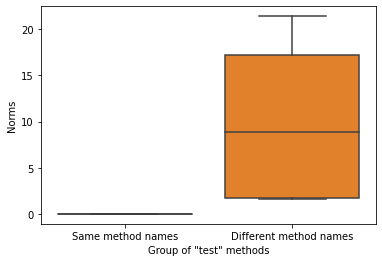

In [366]:
t_test_method('test', 0)

In [ ]:


sns.distplot(df.Principal,ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.distplot(df.terms,ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.barplot(data = df[['Less_than_College', 'college', 'Bachelor']],ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.add_subplot(2, 2, 4)
sns.boxplot(df['age'],ax=ax)
plt.show()

Testing method test:
    Testing 1/2: Ttest_relResult(statistic=-9.543713794405777, pvalue=9.268954296736632e-13)
    Testing 2/2: Ttest_relResult(statistic=-9.543713919150173, pvalue=9.268950396846466e-13)
Testing method appendTo:
    Testing 1/2: Ttest_relResult(statistic=2.6669609425840384, pvalue=0.010342807238237052)
    Testing 2/2: Ttest_relResult(statistic=2.3786131567248185, pvalue=0.02131987233509723)
Testing method repeat:
    Testing 1/2: Ttest_relResult(statistic=2.6687452614811087, pvalue=0.01029509246283518)
    Testing 2/2: Ttest_relResult(statistic=2.9077677107554325, pvalue=0.005455570993049884)
Testing method toString:
    Testing 1/2: Ttest_relResult(statistic=-3.919437537740421, pvalue=0.0002755198325268055)
    Testing 2/2: Ttest_relResult(statistic=-3.864153199661207, pvalue=0.00032781517954054814)
Testing method testItems:
    Testing 1/2: Ttest_relResult(statistic=-10.588232399695254, pvalue=2.917261275391741e-14)
    Testing 2/2: Ttest_relResult(statistic=-10.

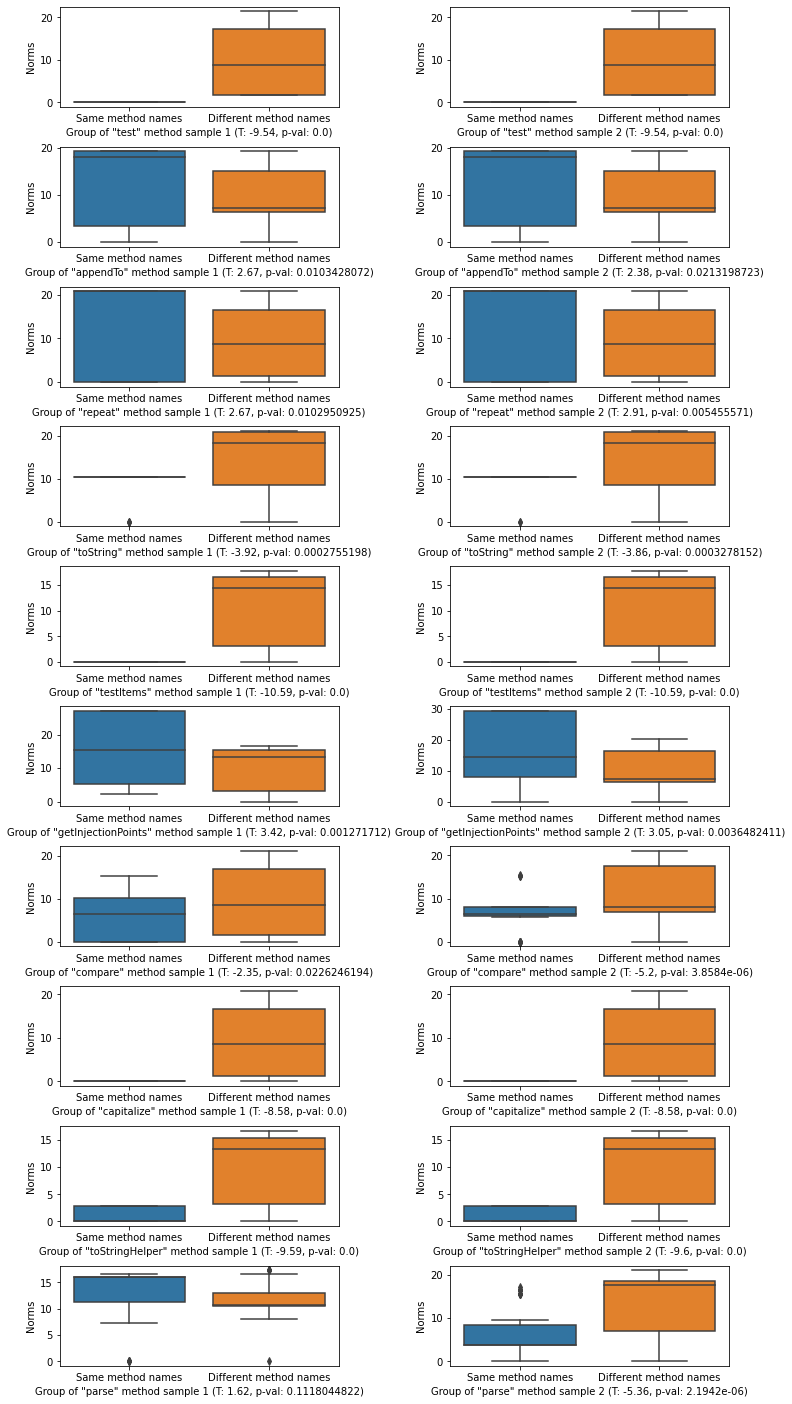

In [385]:
fig = plt.figure()
fig.set_size_inches(12, 25)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
row = 1
for method,function_dataset in ten_funcs.items():
    
    print(f"Testing method {method}:")
    for i in range(0,2):
        ax = fig.add_subplot(10, 2, row)
        r = t_test_method(method, i, ax)
        row += 1
        print(f"    Testing {i+1}/2: {r}")
plt.savefig("test.pdf")

In [ ]:
x = ten_funcs['test'].unique('method_body')

In [ ]:
x 

In [ ]:
[(a, b) for idx, a in enumerate(test_list) for b in test_list[idx + 1:]]

In [ ]:
google_compare_emb = func_compare_google.select(range(0,250)).map(calculate_embeddings, batched=True)

In [ ]:
netty_compare_emb = func_compare_netty.map(calculate_embeddings, batched=True)

In [ ]:
func_CPI_google_emb = func_CPI_google.select(range(0,250)).map(calculate_embeddings, batched=True)

Sanity check that shapes match

In [ ]:
assert np.array(google_compare_emb['embedding']).shape[0] == np.array(netty_compare_emb['embedding']).shape[0]
assert np.array(google_compare_emb['embedding']).shape[1] == np.array(netty_compare_emb['embedding']).shape[1]
assert np.array(google_compare_emb['embedding']).shape[0] == minimum_funcs
assert np.array(google_compare_emb['embedding']).shape[1] == tracebert_model.config.hidden_size

## Add embeddings to dataset and search

We start by selecting a more workable subset of the Google dataset

In [ ]:
ten_k_google = (
                google_train_dataset_enc
                .select(range(0,10000))
                .map(
                      calculate_embeddings,
                      batched=True
                    )
                )

In [ ]:
ten_k_google = ten_k_google.map(lambda x: {'len': len(x['method_body']) })

In [ ]:
ten_k_google.filter(lambda x: x['len'] > 350 and x['method_name'] == 'compare')[0]

In [ ]:
ten_k_google.load_faiss_index('index_flat_ip', 'ten_k_google_ip.faiss')

In [ ]:
ten_k_google.load_faiss_index('index_flat_l2', 'ten_k_google_l2.faiss')

We add a FAISS index to make this dataset searchable

TODO: A custom index can/should be used to improve performance. There are many, many indexes to choose from and have complexity and space considerations, and exhaustion considerations. We can probably handle much, much more traces if we figure this out. Upfront compute is probably higher as well.

In [ ]:
# this is the DEFAULT config, seems to be flat index with IP metric
# note there is a problem with this index: the vectors are supposed to be
# normalized for inner product if we want to find cosine similarity
ten_k_google.add_faiss_index(
    column='embedding',
    index_name='index_flat_ip',
    #device=0, # GPU index
    # passed to faiss.index_factory(), defaults to IndexFlatIP
    string_factory='Flat',
    metric_type=faiss.METRIC_INNER_PRODUCT, # or faiss.METRIC_INNER_PRODUCT
    #custom_index= can specify a custom index object for more power
    #train_size: Optional[int] = None,
    faiss_verbose=True
)

In [ ]:
# let's add an index with L2 distance
ten_k_google.add_faiss_index(
    column='embedding',
    index_name='index_flat_l2',
    #device=0, # GPU index
    string_factory='Flat',
    metric_type=faiss.METRIC_L2,
    #custom_index= can specify a custom index object for more power
    #train_size: Optional[int] = None,
    faiss_verbose=True
)

Let's check if we can access our index directly...

In [ ]:
faiss_index = ten_k_google.get_index('index_flat_ip') # this should return a FAISS object
faiss_index

We save the index so that we don't have to recalculate next time

In [ ]:
ten_k_google.save_faiss_index('index_flat_ip', 'ten_k_google_ip.faiss')
ten_k_google.save_faiss_index('index_flat_l2', 'ten_k_google_l2.faiss')

As a sanity check, we search for an example in the dataset/index and evaluate the top ten results

In [ ]:
random_example_in = ten_k_google[np.random.randint(0, len(ten_k_google))]
random_example_in

In [ ]:
np.array(random_example_in['embedding']).shape

In [ ]:
scores, examples = ten_k_google.get_nearest_examples('index_flat_ip',
                                  np.array(random_example_in['embedding']).astype('float32'),
                                  k=10)

In [ ]:
random_example_in['text']

In [ ]:
# so why are traces with the exact same 'text' not the same distance?

In [ ]:
list(zip(scores, np.sqrt(scores), examples['text']))

We then load one example not in the smaller dataset

In [ ]:
random_example_out = google_train_dataset_enc[np.random.randint(10000, len(google_train_dataset_enc))]

In [ ]:
random_example_out['embedding'] = np.array(calculate_embeddings({'input_ids': [random_example_out['input_ids']],
                                                        'token_type_ids': [random_example_out['token_type_ids']],
                                                        'attention_mask': [random_example_out['attention_mask']] })['embedding'])

In [ ]:
# Sanity check on embedding dim
assert random_example_out['embedding'].shape == (512,)
random_example_out['embedding'].shape

We then search for the example outside of the dataset and evaluate the top 10 results

In [ ]:
# inner product
scores, results = ten_k_google.get_nearest_examples('index_flat_ip', np.array(random_example_out['embedding']).astype('float32'), k=10)


In [ ]:
random_example_out['func_name']

In [ ]:
list(zip(scores, examples['func_name']))

In [ ]:
# l2
ten_k_google.get_nearest_examples('ten_k_google_l2', np.array(random_example_out['embedding']).astype('float32'), k=3)


In [ ]:
# l2 search/distance
distance, index = ten_k_google.get_index('index_flat_l2').search(np.array(random_example_out['embedding']).astype('float32'), k=3)
print(f"Distance by FAISS: {np.sqrt(distance)}, index: {index}")

#### Cosine similarity index + search

Let's create a new index so we can calculate cosine similarity

In [ ]:
random_example_emb = np.array(random_example_out['embedding']).astype('float32')
#x = np.array([random_example_emb])#.astype(np.float32)
#q = np.array([random_example_emb])#.astype(np.float32)
faiss_l2_index = faiss.index_factory(512, "Flat", faiss.METRIC_L2)

For cosine similarity, we *must* normalize the index vectors and the search vectors

In [ ]:
ten_k_emb_norm = np.array(ten_k_google['embedding']).astype('float32')
random_example_emb_in = np.array([random_example_in['embedding']]).astype('float32')
faiss.normalize_L2(ten_k_emb_norm) # must normalize ALL vectors for this index
faiss_l2_index.train(ten_k_emb_norm)
# faiss.normalize_L2(random_example_emb)
faiss_l2_index.add(ten_k_emb_norm)

Sanity check:

In [ ]:
faiss_l2_index.is_trained

In [ ]:
faiss_l2_index.ntotal # should be one
#faiss_l2_index.train(training_vectors)
faiss_l2_index.add(random_example_emb)
distance, index = faiss_l2_index.search(random_example_emb, 1)
print(f"Distance by FAISS: {np.sqrt(distance)}, index: {index}")

In [ ]:
distance, index = faiss_inner_prod_index.search(random_example_emb, 1)
print(f"Distance by FAISS: {distance}, index: {index}")

In [ ]:
# calculate cosine similarity
from scipy import spatial, stats

In [ ]:
result = 1 - spatial.distance.cosine(ten_k_emb_norm[index[0]], random_example_emb)
print(f"Distance by scipy: {result}")

In [ ]:
np.array(google_compare_emb['embedding']).shape

In [ ]:
np.linspace(0, 1, np.array(google_compare_emb['embedding']).shape[0])

In [ ]:
import pandas as pd

In [ ]:
ax1 = np.linalg.norm(np.array(google_compare_emb['embedding'][:125])-np.array(func_CPI_google_emb['embedding'][125:250]), axis=1)

In [ ]:
ax2 = np.linalg.norm(np.array(google_compare_emb['embedding'][:125]),axis=1) - np.linalg.norm(np.array(func_CPI_google_emb['embedding'][125:250]),axis=1)

In [ ]:
ax2 = np.linalg.norm(np.array(google_compare_emb['embedding'][:125]),axis=1) - np.linalg.norm(np.array(func_CPI_google_emb['embedding'][125:250]),axis=1)
pd.DataFrame(ax2).hist(grid=False,
       figsize=(10, 6),
       )
stats.ttest_rel(ax1, ax2)

In [ ]:
stats.ttest_rel(ax1, ax2)

In [ ]:
ax1 = np.linalg.norm(np.array(google_compare_emb['embedding'][:125])-np.array(func_CPI_google_emb['embedding'][125:250]), axis=1)

In [ ]:
ax2 = np.linalg.norm(np.array(google_compare_emb['embedding'][:125]),axis=1) - np.linalg.norm(np.array(func_CPI_google_emb['embedding'][125:250]),axis=1)

In [ ]:
stats.ttest_rel(ax1, ax2)

In [ ]:
np.linalg.norm(np.array(func_CPI_google_emb['embedding'][125:250]),axis=1)

In [ ]:
np.mean(np.linalg.norm(np.array(func_CPI_google_emb['embedding'][125:250]),axis=1))

In [ ]:
np.mean(np.linalg.norm(np.array(google_compare_emb['embedding'][:125]),axis=1))

In [ ]:
np.linalg.norm(np.array(google_compare_emb['embedding'][:250])-np.array(func_CPI_google_emb['embedding'][:250]),axis=1)

In [ ]:
np.array(func_CPI_google_emb['embedding'][:125])

In [ ]:
np.array(func_CPI_google_emb['embedding'][125:250])

In [ ]:
np.array(google_compare_emb['embedding'][:125])-np.array(func_CPI_google_emb['embedding'][:125])

In [ ]:
np.linalg.norm(np.array(google_compare_emb['embedding'][:125])-np.array(func_CPI_google_emb['embedding'][:125]),axis=1)

## t Test

In [ ]:
np.array(google_compare_emb['embedding'][:50])

In [ ]:
np.linalg.norm(np.array(google_compare_emb['embedding'][:125])-np.array(google_compare_emb['embedding'][125:250]))

In [ ]:
np.linalg.norm(np.array(google_compare_emb['embedding'][:250])-np.array(func_CPI_google_emb['embedding'][:250]))

In [ ]:
a = np.linalg.norm(np.array(google_compare_emb['embedding'][:125])-np.array(google_compare_emb['embedding'][125:250]), axis=1)
b = np.linalg.norm(np.array(google_compare_emb['embedding'][125:250])-np.array(func_CPI_google_emb['embedding'][:125]), axis=1)
t, p = stats.ttest_rel(a, b)
(t, p)

# tSNE: Are the embeddings really capturing something useful?

In [386]:
from MulticoreTSNE import MulticoreTSNE as TSNE
#from tsnecuda import TSNE # pkg: tsnecuda
from matplotlib import cm
import matplotlib

In [405]:
def draw_tsne(embeddings, colors):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    embeddings_tsne = TSNE(n_jobs=16).fit_transform(embeddings)
    vis_x_cb = embeddings_tsne[:, 0]
    vis_y_cb = embeddings_tsne[:, 1]
    fig = plt.figure(figsize=(36,24))
    ax = fig.add_subplot(111)
    ax.scatter(vis_x_cb, vis_y_cb, c=colors, marker='.')
    ax.set_aspect('equal', adjustable='datalim')
    plt.show()

In [ ]:
np.concatenate([np.array(netty_compare_emb['embedding']), np.array(google_compare_emb['embedding'])]).shape

In [ ]:
draw_tsne(
    np.concatenate([np.array(netty_compare_emb['embedding']), np.array(google_compare_emb['embedding'])]),
    cm.rainbow(np.concatenate((np.zeros(netty_compare_emb.shape[0]), np.ones(google_compare_emb.shape[0]))))
)

In [388]:
np.concatenate([np.array(value['embedding']) for (key,value) in ten_funcs.items()]).shape

(6072, 512)

In [394]:
color_indices = []
j = 0
for key,value in tqdm(ten_funcs.items()):
    color_indices.extend([j for k in range(len(value))])
    j += 1
np.array(color_indices)

  0%|          | 0/10 [00:00<?, ?it/s]

array([0, 0, 0, ..., 9, 9, 9])

In [404]:
np.array(color_indices).shape

(6072,)

<Figure size 1332x756 with 0 Axes>

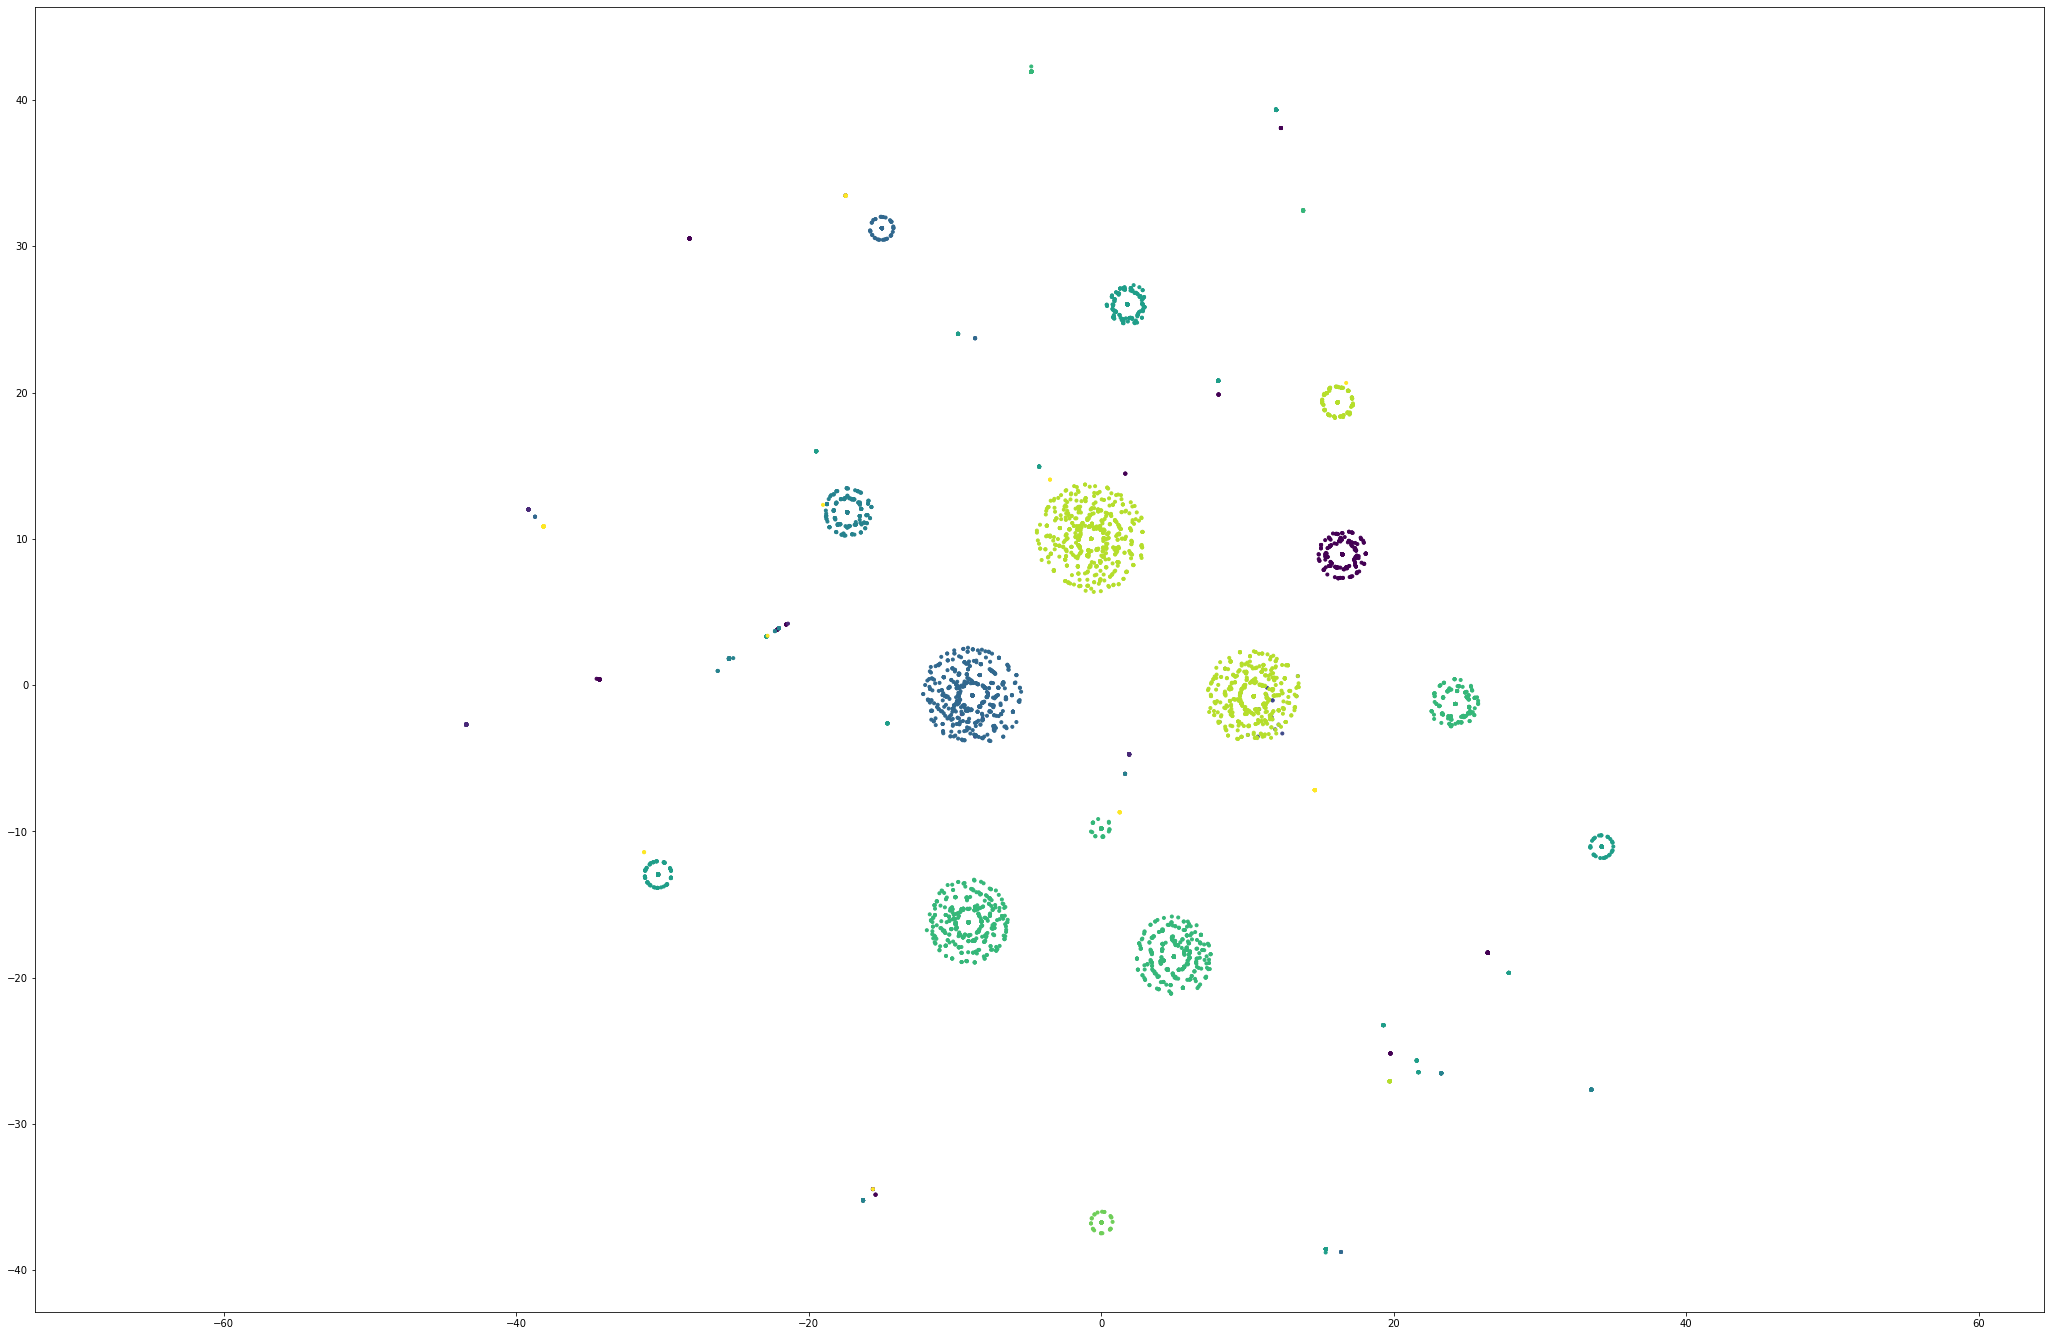

In [406]:
draw_tsne(
    np.concatenate([np.array(value['embedding']) for (key,value) in ten_funcs.items()]),
    np.array(color_indices)
)

In [407]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
embeddings_tsne = TSNE(n_jobs=16).fit_transform(np.concatenate([np.array(value['embedding']) for (key,value) in ten_funcs.items()]))
vis_x_cb = embeddings_tsne[:, 0]
vis_y_cb = embeddings_tsne[:, 1]

<Figure size 1332x756 with 0 Axes>

In [418]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [419]:
cluster_centers = {}
offset = 0
for key,value in tqdm(ten_funcs.items()):
    setlength = len(value)
    cluster_centers[key] = [np.mean(reject_outliers(embeddings_tsne[offset:offset+setlength, 0])), np.mean(reject_outliers(embeddings_tsne[offset:offset+setlength, 1]))]
    offset += setlength
np.array(cluster_centers)

  0%|          | 0/10 [00:00<?, ?it/s]

array({'test': [14.042239563819784, -17.22681932891949], 'appendTo': [-19.702780888061902, 28.80548964431794], 'repeat': [7.755993815579448, -1.2687331454973425], 'toString': [7.240084970353981, -8.10494877904555], 'testItems': [15.488890170161092, 2.1581688152981315], 'getInjectionPoints': [0.06951852096895174, -14.294558103395081], 'compare': [-1.7394039913004045, 5.868466555601717], 'capitalize': [41.174447882483854, 3.837310377272883], 'toStringHelper': [-11.795246056317326, 0.42077471081978907], 'parse': [-27.506340105181437, 19.09373375885983]},
      dtype=object)

In [413]:
embeddings_tsne.shape

(6072, 2)

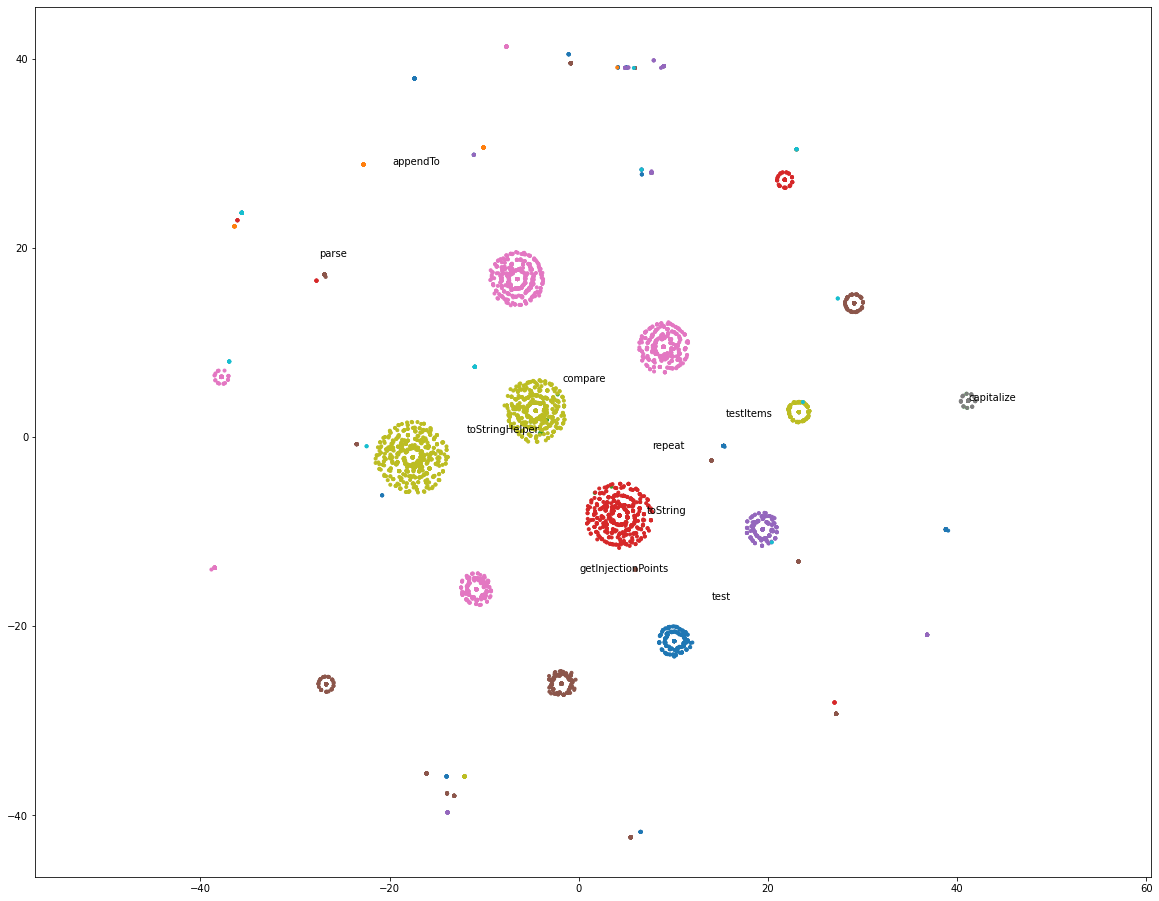

In [431]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111)
ax.scatter(vis_x_cb, vis_y_cb, c=np.array(color_indices), marker='.', cmap='tab10')
for key,cluster in cluster_centers.items():
    ax.text(cluster[0], cluster[1], key)
ax.set_aspect('equal', adjustable='datalim')
plt.savefig('tsne_labeled.pdf')
plt.show()

<Figure size 1332x756 with 0 Axes>

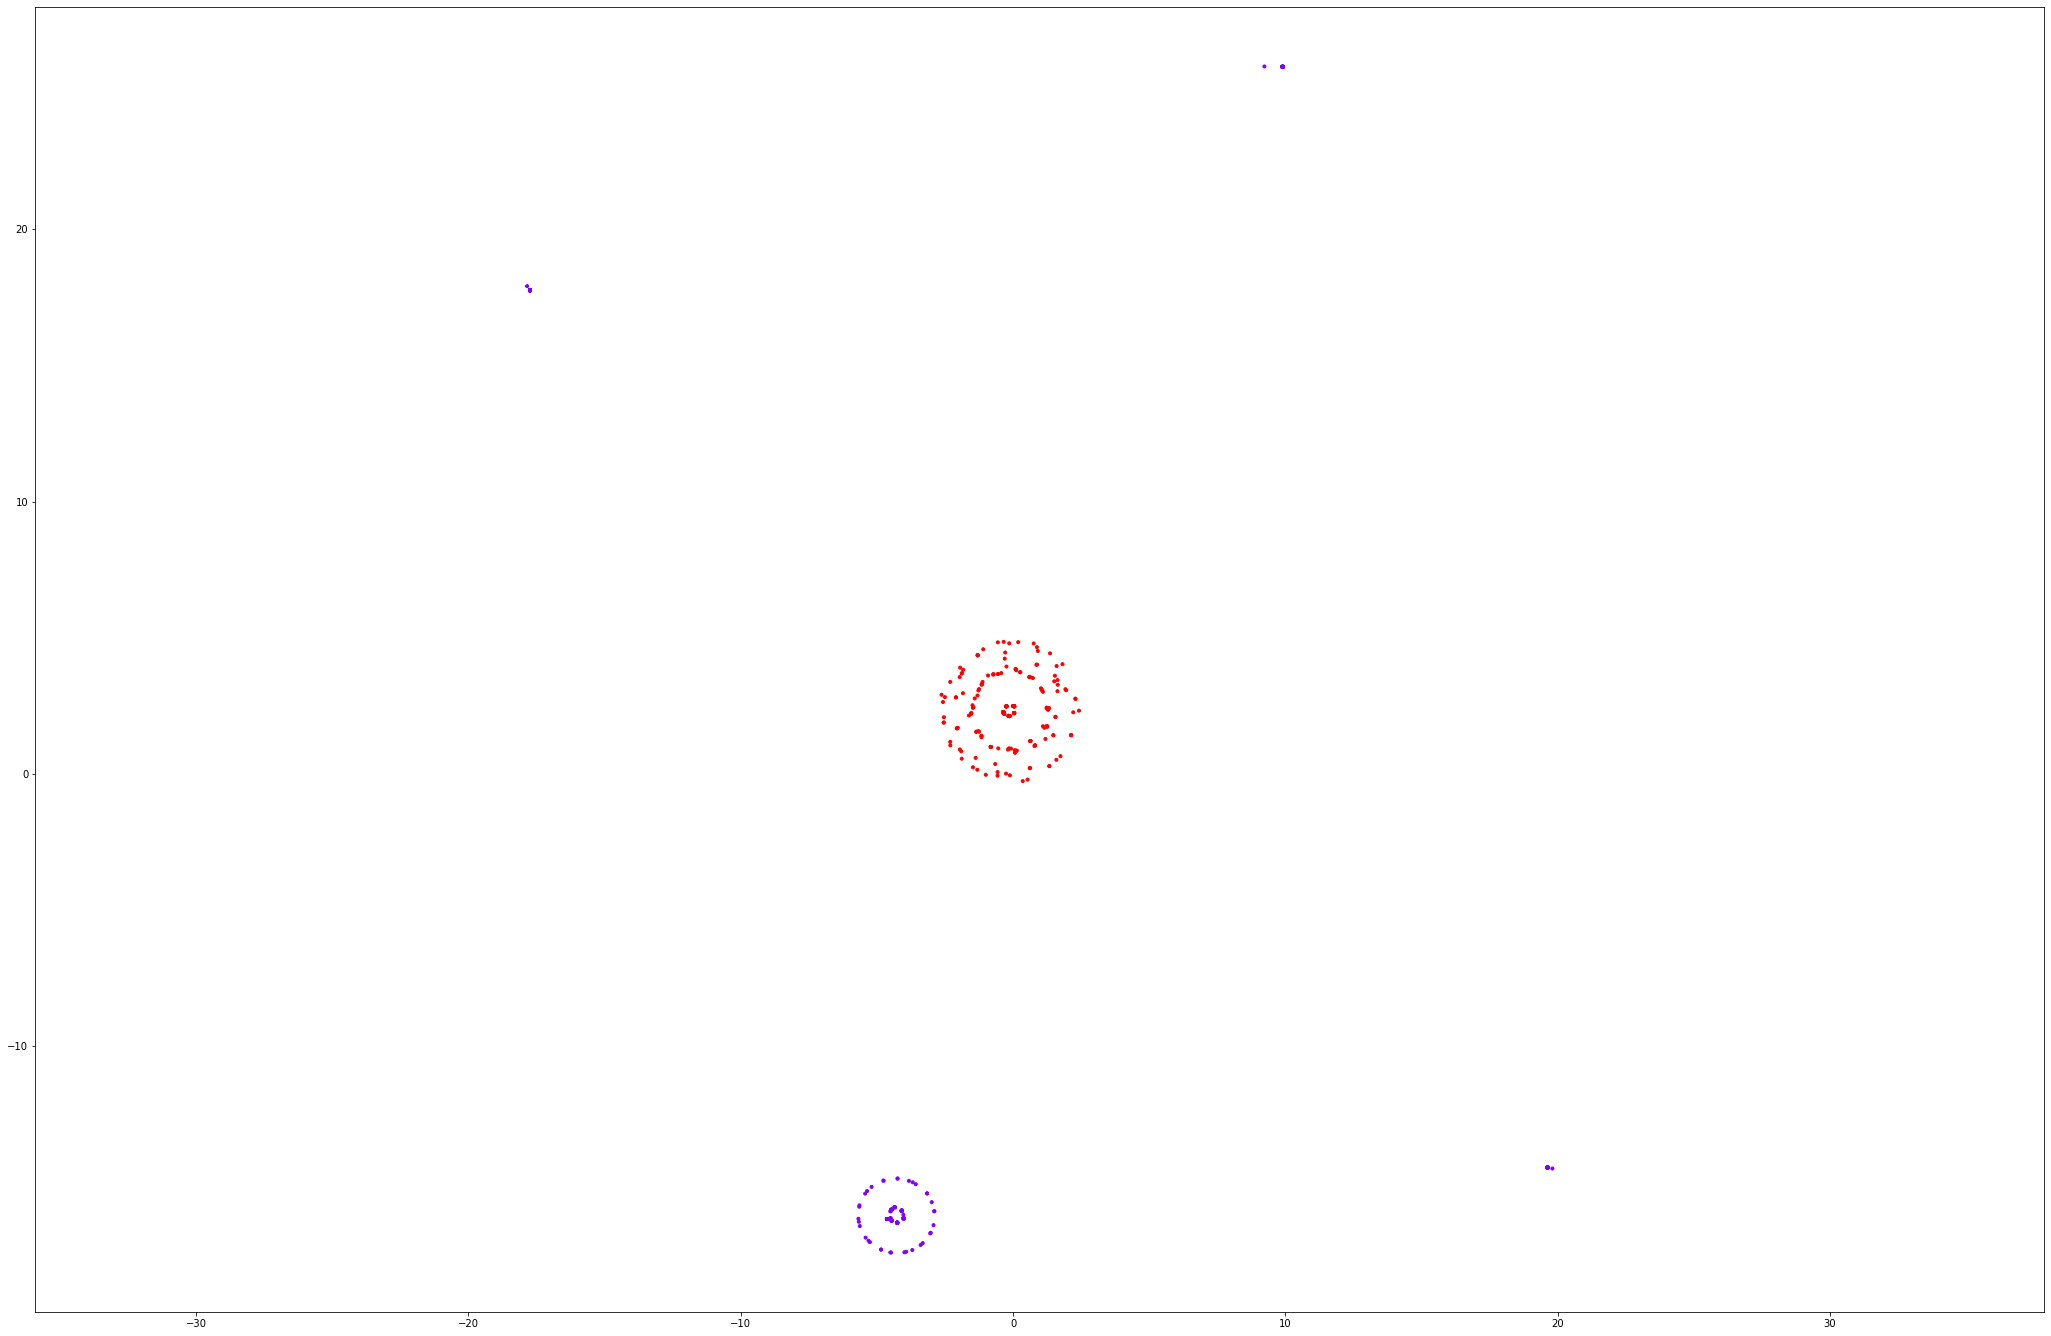

In [416]:
draw_tsne(
    np.concatenate([np.concatenate([np.array(google_compare_emb['embedding']), np.array(func_CPI_google_emb['embedding'])])]),
    cm.rainbow(np.concatenate((np.zeros(google_compare_emb.shape[0]), np.ones(func_CPI_google_emb.shape[0]))))
)

In [426]:
ten_k_emb = np.unique(np.array(ten_k_google['embedding']), axis=0)

<Figure size 1332x756 with 0 Axes>

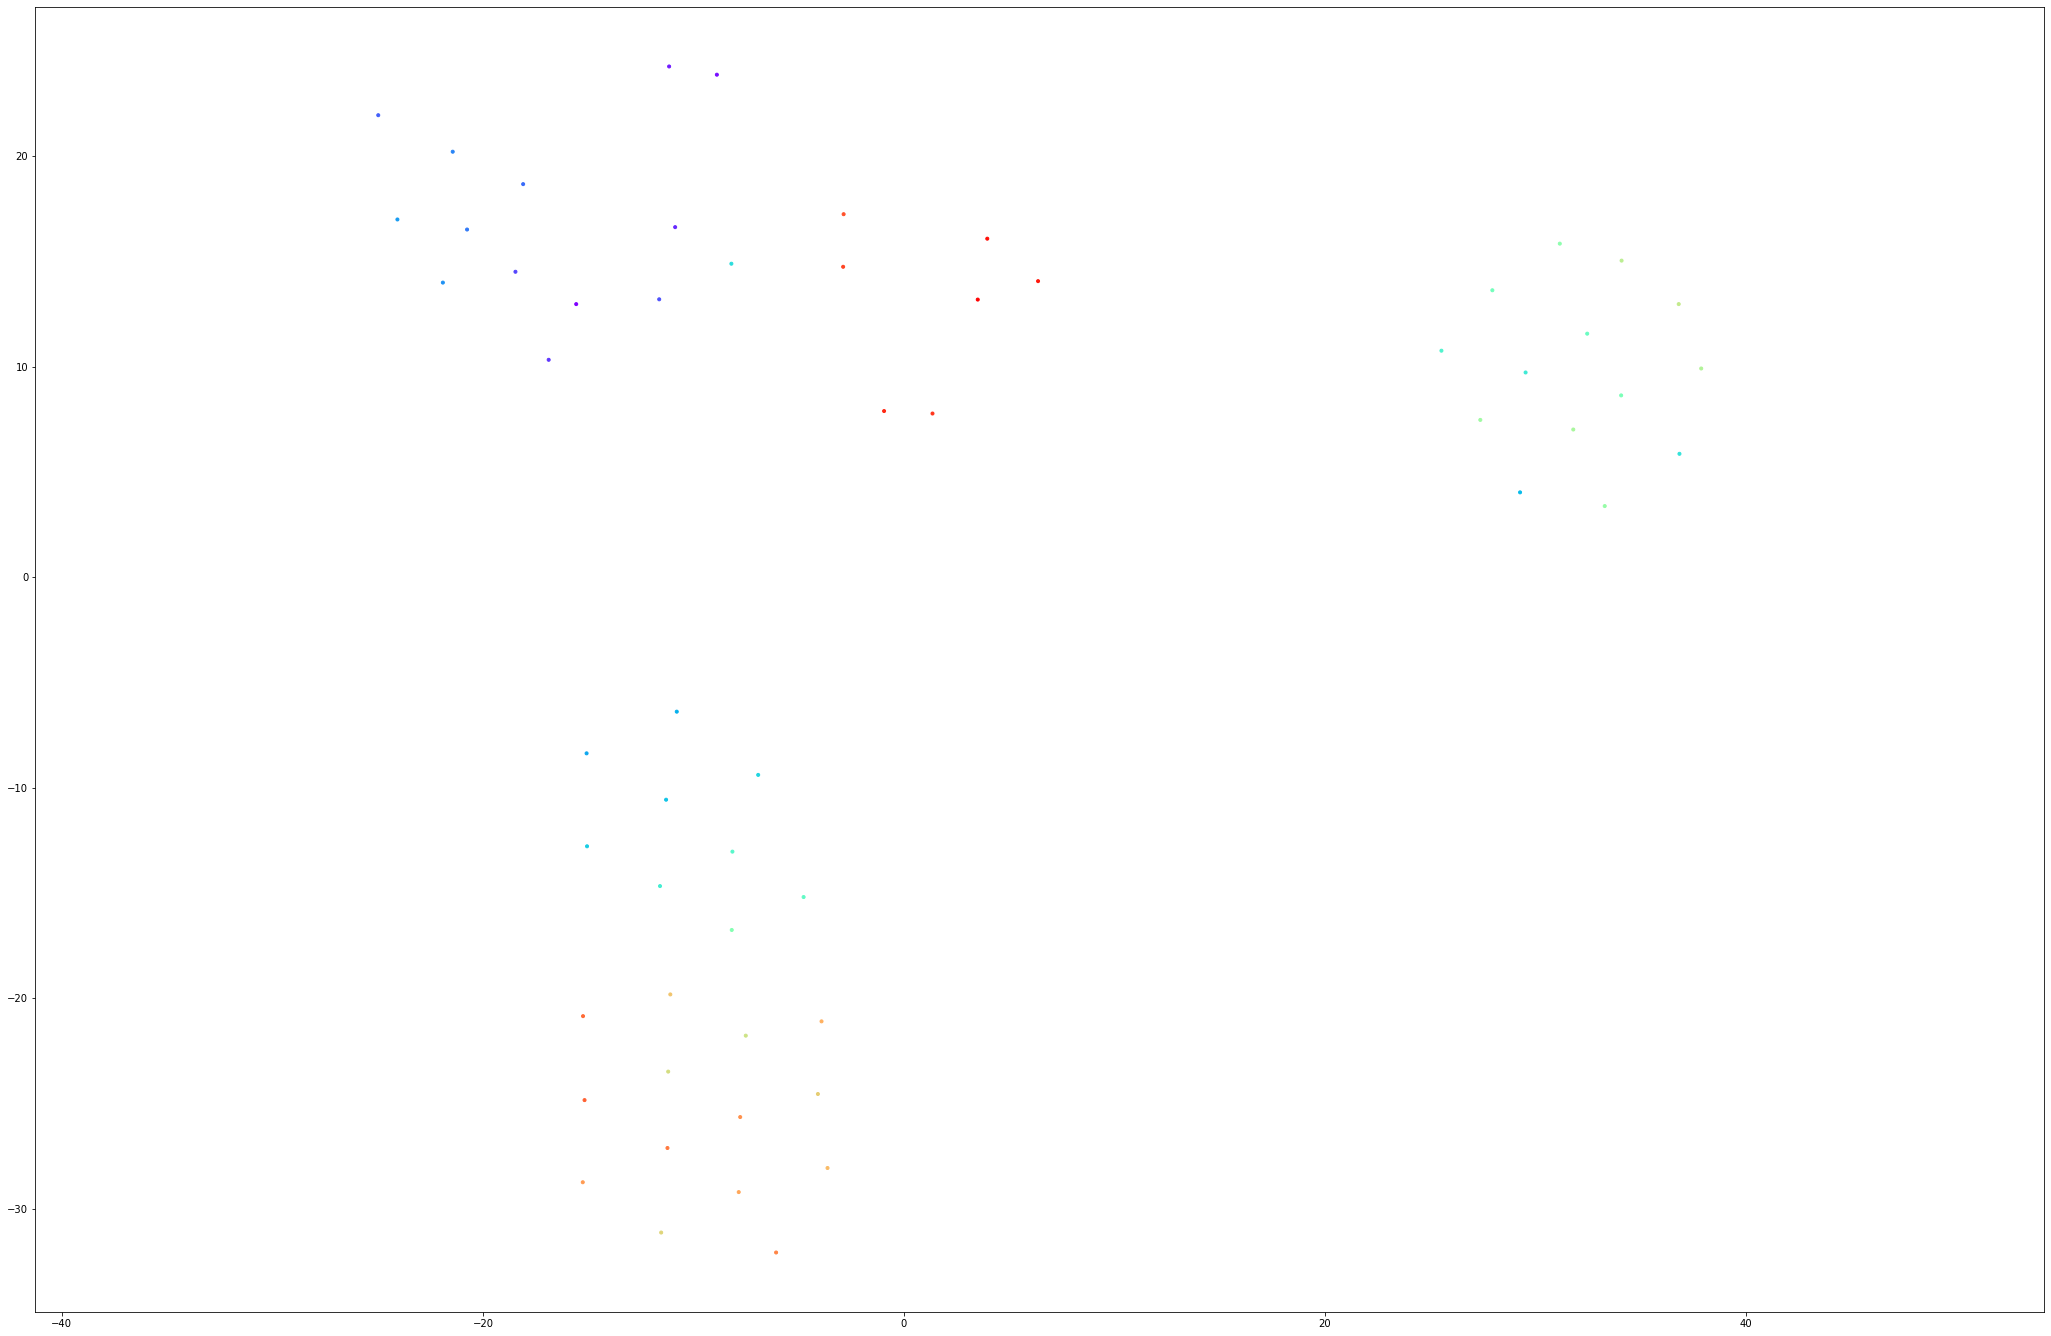

In [429]:
draw_tsne(
    ten_k_emb,
    cm.rainbow(np.linspace(0, 1, ten_k_emb.shape[0])) # what /exactly/ do the colors represent?
)

# Does our model return something useful when asked to fill a mask?

In [ ]:
from transformers import pipeline
from pprint import pprint

unmasker = pipeline(
    "fill-mask",
    model=tracebert_model,
    tokenizer=fast_tokenizer
)

In [ ]:
pprint(
    unmasker((
        "setSuccessorInMultimap "
        "[ENTRY] void com.google.common.collect.LinkedHashMultimap$ValueEntry "
        f"{unmasker.tokenizer.mask_token} "
        "[EXIT]"
    )))

In [ ]:
pprint(
    unmasker((
        f"{unmasker.tokenizer.mask_token} "
        "[ENTRY] void com.google.common.collect.LinkedHashMultimap$ValueEntry "
        "[EXIT]"
    ))
)

# Misc leftovers

#### L2 distance index + search

In [ ]:
random_example_emb = random_example_out['embedding']
#x = np.array([random_example_emb])#.astype(np.float32)
#q = np.array([random_example_emb])#.astype(np.float32)
faiss_l2_index = faiss.index_factory(512, "Flat", faiss.METRIC_L2)

In [ ]:
faiss_l2_index.is_trained

In [ ]:
faiss_l2_index.ntotal # should be one
#faiss_l2_index.train(training_vectors)
faiss_l2_index.add(random_example_emb)
distance, index = faiss_l2_index.search(random_example_emb, 1)
print(f"Distance by FAISS: {np.sqrt(distance)}, index: {index}")

In [ ]:
ds_with_embeddings = encoded_dataset_test.map(lambda example:
                            {'embeddings': np.array([0])})
                             #bertmodel(**fast_tokenizer(example["text"], max_length = 512, truncation=True, padding=True, return_tensors="pt")).hidden_states[-1][0].numpy()},
                                      #  batched=True)

# ds_with_embeddings = encoded_dataset_train.map(lambda example:
#                             {'embeddings': 
#                              bertmodel(**{'attention_mask': torch.tensor(example['attention_mask']),
#                                          'input_ids': torch.tensor(example['input_ids']),
#                                          'token_type_ids': torch.tensor(example['token_type_ids'])})[0].numpy()},
#                                         batched=True)

#    e = np.save("google_ex", bertmodel(**fast_tokenizer(ten_k_google.select(range(0,222))["text"],
#                                  max_length = 512, truncation=True, padding=True, return_tensors="pt",
#                                  )).hidden_states[-1].detach().numpy())
# print(e.shape)

    
    bertmodel(**fast_tokenizer(ten_examples_google["text"],
                                   max_length = 512, truncation=True, padding=True, return_tensors="pt",
                                  )).hidden_states[-1].shape

 netty = np.save("netty_ex", bertmodel(**fast_tokenizer(ten_k_netty["text"],
  max_length = 512, truncation=True, padding=True, return_tensors="pt"
 )).hidden_states[-1].detach().numpy())
index = faiss.IndexFlatL2(512)   # build the index
print(index.is_trained)
index.search(hidden_states.detach().numpy(),k=1)
from torch.nn import functional as F
import torch
#subset = 
smaller_dataset = encoded_dataset_test.shard(num_shards=4000, index=0)
text = "The capital of France, " + fast_tokenizer.mask_token + ",contains the Eiffel Tower."
input = fast_tokenizer.encode_plus(text, return_tensors = "pt").to("cuda")
mask_index = torch.where(input["input_ids"][0] == fast_tokenizer.mask_token_id)
logits = model(**input)
logits = logits.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_word = torch.argmax(mask_word, dim=1)
print(fast_tokenizer.decode(top_word))

softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = fast_tokenizer.decode([token])
   new_sentence = text.replace(fast_tokenizer.mask_token, word)
   print(new_sentence)
smaller_dataset
trainer_eval = trainer.evaluate(smaller_dataset, metric_key_prefix='no')

print(trainer_eval)
metrics = train_result.metrics
print(metrics)
#trainer.log_metrics("train", compute_metrics)
#trainer.save_metrics("train", compute_metrics)
#trainer.save_state()

print(metric.inputs_description)
model_predictions = model(smaller_dataset)
final_score = metric.compute(predictions=model_predictions, references=gold_references)

In [ ]:
test_input = fast_tokenizer(["performExpensiveLogSetup [ENTRY] void [CALL] java.io.PrintStream println java.lang.String void [EXIT] [CALL] java.lang.Math pow double|double double [CALL] java.lang.Math sqrt double double [CALL] java.io.PrintStream println java.lang.String void [EXIT]", "[EXIT]", ""], max_length = 512, truncation=True, padding=True, return_tensors="pt")
#fast_tokenizer.encode("performExpensiveLogSetup [ENTRY] void [CALL] java.io.PrintStream println java.lang.String void [EXIT] [CALL] java.lang.Math pow double|double double [CALL] java.lang.Math sqrt double double [CALL] java.io.PrintStream println java.lang.String void [EXIT]", max_length = 512, truncation=True, padding=True, return_tensors="pt")
hidden_states = bertmodel(**test_input).hidden_states

last_four_layers = [hidden_states[i] for i in (-1, -2, -3, -4)]
# cast layers to a tuple and concatenate over the last dimension
cat_hidden_states = torch.cat(tuple(last_four_layers), dim=-1)
print(cat_hidden_states.size())

# take the mean of the concatenated vector over the token dimension
cat_sentence_embedding = torch.mean(cat_hidden_states, dim=1).squeeze()
print(cat_sentence_embedding.size())
bertmodel(**fast_tokenizer("performExpensiveLogSetup [ENTRY] void [CALL] java.io.PrintStream println java.lang.String void [EXIT] [CALL] java.lang.Math pow double|double double [CALL] java.lang.Math sqrt double double [CALL] java.io.PrintStream println java.lang.String void [EXIT]", max_length = 512, truncation=True, padding=True, return_tensors="pt"))[1][0].numpy().shape
inputs = {
    "input_ids": encoded_dataset_test[0],
   #"attention_mask": batch[1]
}
input_sentence = torch.tensor(fast_tokenizer.encode("performExpensiveLogSetup [ENTRY] void [CALL] java.io.PrintStream println java.lang.String void [EXIT] [CALL] java.lang.Math pow double|double double [CALL] java.lang.Math sqrt double double [CALL] java.io.PrintStream println java.lang.String void [EXIT]", max_length = 512, truncation=True, padding=True)).unsqueeze(0)
output = bertmodel(input_sentence)
logits = output[0]
hidden_states = output[1]

In [ ]:
#assert both_embeddings.shape == (444, 512)

In [ ]:
#colors = cm.rainbow(np.linspace(0, 1, len(both_embeddings)))
colors = cm.rainbow(np.concatenate((np.zeros(222), np.ones(222)))) # TODO

In [ ]:
embeddings_tsne = TSNE(n_jobs=16).fit_transform(both_embeddings)

point_of_interest = [46,27] # what are these?

def find_idx(e):
    return np.linalg.norm(point_of_interest-e)

def get_idx(e):
    return np.argsort(np.linalg.norm(point_of_interest-e, axis=1))

points = 100
test_embeddings = sorted(embeddings_tsne, key=find_idx)
test_points = np.array(test_embeddings)
center = test_points[0:points].mean(axis=0)
width = np.linalg.norm(point_of_interest-test_points[0:points][-1], axis=-1)
test_embedding_indexs = get_idx(np.array(embeddings_tsne))[:points]
equivalent_points = np.array(embeddings_tsne)[test_embedding_indexs]
center = equivalent_points.mean(axis=0)
cir = plt.Circle(center, width, color='r', fill=False)

In [ ]:
vis_x_cb = embeddings_tsne[:, 0]
vis_y_cb = embeddings_tsne[:, 1]

In [ ]:
fig = plt.figure(figsize=(36,24))
ax = fig.add_subplot(111)
ax.scatter(vis_x_cb, vis_y_cb, color=colors, marker='.')
ax.set_aspect('equal', adjustable='datalim')
#ax.add_patch(cir)
plt.show()

In [ ]:
# embedding comes from bertmodel(**fast_tokenizer(ten_k_netty["text"],
 # max_length = 512, truncation=True, padding=True, return_tensors="pt"
 #)).hidden_states[-1].detach().numpy()
# embeddings[:,:1,:].squeeze()
#    both_embeddings = np.concatenate([embeddings_a, embeddings_b])
# both_embeddings.shape should be (444, 512) because 222 examples * 2 * 512 dimensions